In [45]:

import csv
import pandas as pd
import platform
import time
import json
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
os.chdir('C:/Users/e19439/Downloads/')
path = os.getcwd()

print(path)

C:\Users\e19439\Downloads


In [163]:
data = pd.read_csv('churn_data.csv')
# checking columns and data types to ensure the columns have the correct type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [164]:
# converting wrong columns, in this case TotalCharges to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')


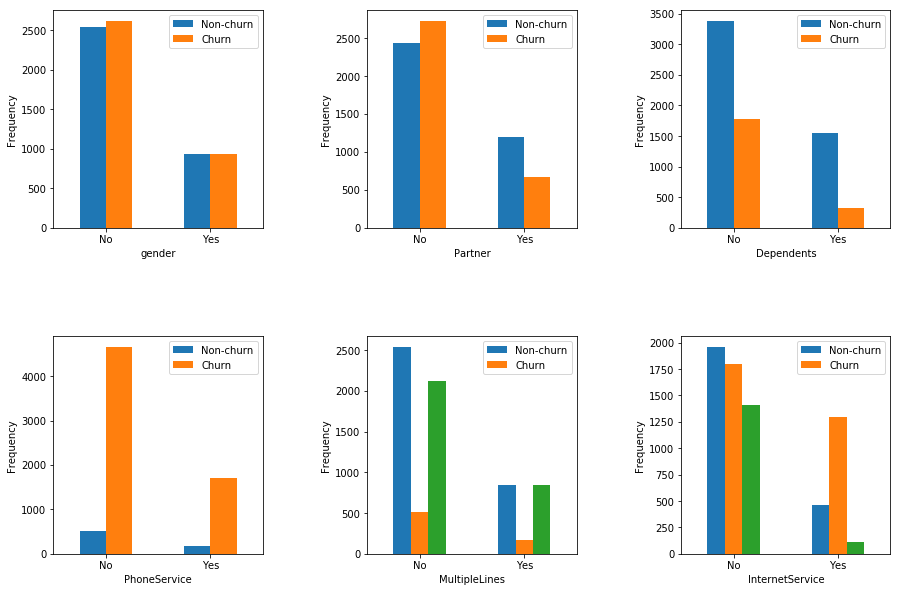

In [165]:
# plotting the distributions of the categorical variables by churn vs non-churn

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace = 0.5, wspace=0.5)
axs = axs.ravel()

cat_vars = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService']
for i, var in enumerate(cat_vars):
    data.groupby(['Churn', var])[var].count().unstack().plot(kind='bar', ax=axs[i], rot=0)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Frequency')
    axs[i].legend(['Non-churn', 'Churn'])

plt.show()

In [166]:
# Check for missing values
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [160]:
# dropping missing values and removing customerID
data.dropna(inplace = True)
data = data.iloc[:,1:]
# Converting categorical variables to numerical variables
data['gender'] = pd.factorize(data['gender'])[0]
data['Partner'] = pd.factorize(data['Partner'])[0]
data['Dependents'] = pd.factorize(data['Dependents'])[0]
data['PhoneService'] = pd.factorize(data['PhoneService'])[0]
data['MultipleLines'] = pd.factorize(data['MultipleLines'])[0]
data['InternetService'] = pd.factorize(data['InternetService'])[0]
data['OnlineSecurity'] = pd.factorize(data['OnlineSecurity'])[0]
data['OnlineBackup'] = pd.factorize(data['OnlineBackup'])[0]
data['DeviceProtection'] = pd.factorize(data['DeviceProtection'])[0]
data['TechSupport'] = pd.factorize(data['TechSupport'])[0]
data['StreamingTV'] = pd.factorize(data['StreamingTV'])[0]
data['StreamingMovies'] = pd.factorize(data['StreamingMovies'])[0]
data['Contract'] = pd.factorize(data['Contract'])[0]
data['PaperlessBilling'] = pd.factorize(data['PaperlessBilling'])[0]
data['PaymentMethod'] = pd.factorize(data['PaymentMethod'])[0]
data['Churn'] = pd.factorize(data['Churn'])[0]

data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [135]:
# looking at our changes so far
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29.85,29.85,0
1,1,0,1,0,34,1,1,0,1,1,1,0,0,0,1,1,1,56.95,1889.50,0
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,53.85,108.15,1
3,1,0,1,0,45,0,0,0,1,1,1,1,0,0,1,1,2,42.30,1840.75,0
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,70.70,151.65,1


In [136]:
# seeing how balanced our data set is 
print(data['Churn'].value_counts())

0    5163
1    1869
Name: Churn, dtype: int64


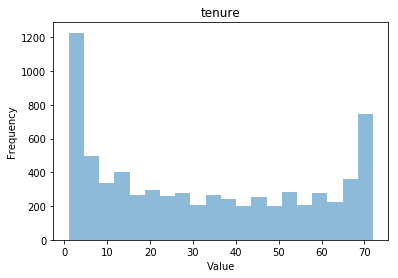

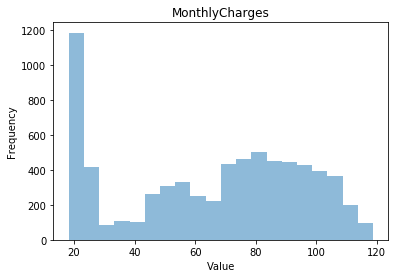

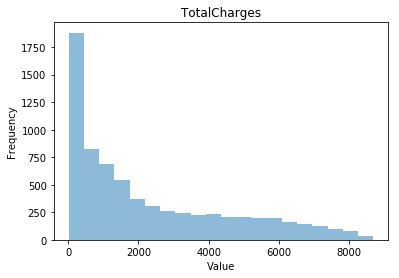

In [138]:
# creating a list of numerical column names
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# looping through each numerical column and create a histogram to see the distribution
for col in num_cols:
    plt.hist(data[col], bins=20, alpha=0.5)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

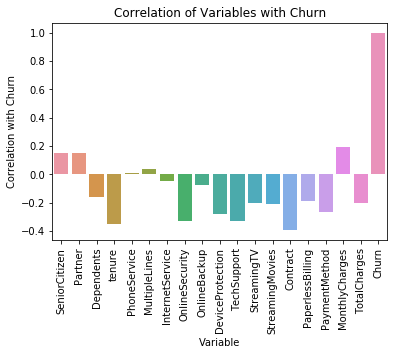

In [137]:
# creating and plotting a correlation matrix
sns.barplot(x=corr['Churn'].index[1:], y=corr['Churn'][1:])
plt.title('Correlation of Variables with Churn')
plt.xlabel('Variable')
plt.ylabel('Correlation with Churn')
plt.xticks(rotation=90)
plt.show()

In [139]:
# dropping low correlation variables, this did not end up helping so I commented out to show work but not include in final result
# data.drop(columns = ['PhoneService', 'MultipleLines', 'InternetService'],inplace = True)

In [140]:
# using
X = data.drop(columns = ['Churn'])
y = data['Churn'].values


In [141]:
# Split the data into training and testing sets

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [142]:
from sklearn import metrics

# Modeling with logistic regression
model = LogisticRegression()
result = model.fit(X_train, y_train)

prediction_test = model.predict(X_test)
# finding model accuracy
print (metrics.accuracy_score(y_test, prediction_test))

0.7919431279620853


AxesSubplot(0.125,0.125;0.775x0.755)


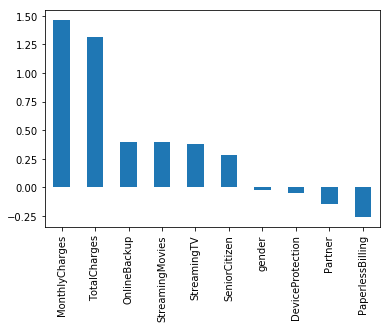

In [143]:
# plotting variable weights
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


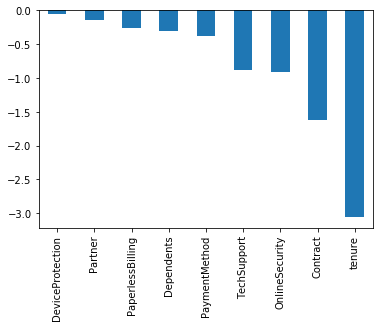

In [144]:
print(weights.sort_values(ascending = False)[-9:].plot(kind='bar'))

In [145]:
# Using random forest, experimented with test split size and hyperparamaters here
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
rf = RandomForestClassifier(n_estimators=1900 , #max_depth = 100,
                                  random_state =42, max_features = "sqrt",
                                  min_samples_split = 10)

rf.fit(X_train, y_train)
prediction_test = rf.predict(X_test)

accuracy = accuracy_score(y_test, prediction_test)
precision = precision_score(y_test, prediction_test)
recall = recall_score(y_test, prediction_test)
f1 = f1_score(y_test, prediction_test)
results = pd.DataFrame([[accuracy, precision, recall, f1]], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(results)

   Accuracy  Precision    Recall  F1 Score
0  0.790102   0.629738  0.471616  0.539326


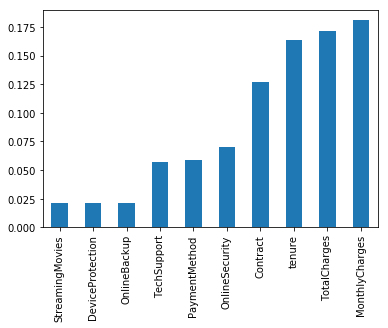

In [146]:
# Get the feature importances from the random forest regressor
importances = rf.feature_importances_


# Print the feature ranking
weights = pd.Series(importances,index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'bar')